# Explore here

In [213]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import *
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
import joblib


# Cargar datos

In [214]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


# Revisión inicial de datos

In [215]:
# Revisar dimensiones y características de las columnas disponibles
print(df.shape)
print(df.dtypes)

(366, 2)
date      object
sales    float64
dtype: object


In [216]:
# Identificación de valores únicos
df.nunique()

date     366
sales    366
dtype: int64

In [217]:
# Identificación de valores faltantes
df.isna().mean()*100

date     0.0
sales    0.0
dtype: float64

In [218]:
# Identificación de duplicados
df.duplicated().sum()

np.int64(0)

La columna que contiene las fechas no está en formato fecha. Por lo tanto, la transformaremos para poder hacer uso de ella más adelante.

In [219]:
# Transformamos el formato a fecha
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True) # Se establece ésta columna como índice. 

# Analizar la serie temporal 

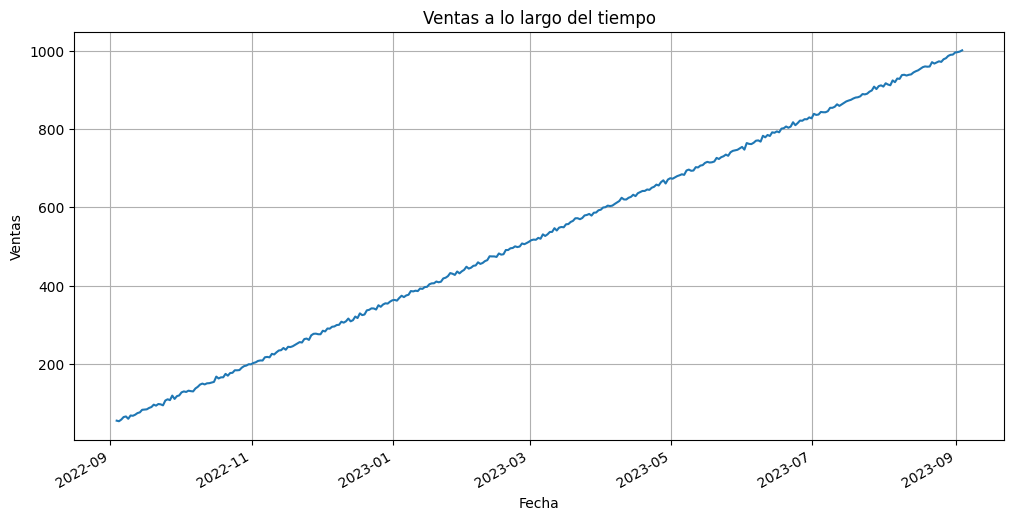

In [220]:
import matplotlib.pyplot as plt

df['sales'].plot(figsize=(12, 6), title='Ventas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()

Como se describía en el enunciado, las ventas han crecido desde septiembre del 2022 hasta el mismo mes del año 2023.

In [221]:
# Vemos los tensores de nuestra serie
print(df.index.to_series().diff().value_counts())

date
1 days    365
Name: count, dtype: int64


Las fechas de la serie temporal tienen una frecuencia diaria, con una diferencia de 1 día entre registros a lo largo de 365 filas. Es decir el tensor de la serie temporal es diario.

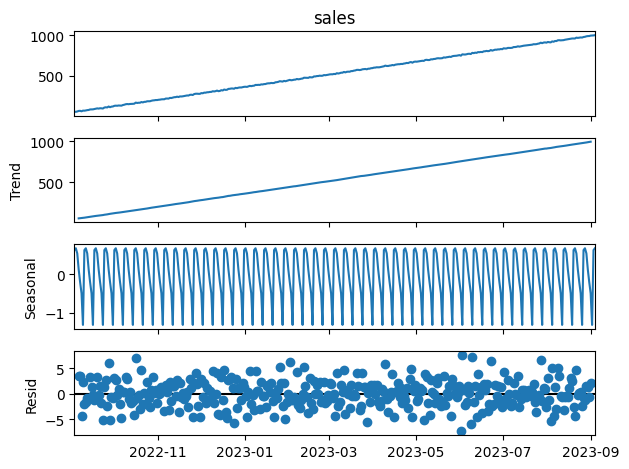

In [222]:
# Para analizar esta serie temporal utilizamos seasonal_decompose
decomp = sm.tsa.seasonal_decompose(df['sales'], model='additive', period=7)  # se analiza periodos de una semana (period=7)
decomp.plot()
plt.show()

In [223]:
# Revisión de la estacionalidad mostrada en el gráfico anterior
decomp.seasonal.head(14) # Selección de las primeras 14 observaciones del componente estacional de la serie.

date
2022-09-03 17:10:08.079328    0.637205
2022-09-04 17:10:08.079328    0.685388
2022-09-05 17:10:08.079328    0.551760
2022-09-06 17:10:08.079328    0.132276
2022-09-07 17:10:08.079328   -0.197866
2022-09-08 17:10:08.079328   -0.492453
2022-09-09 17:10:08.079328   -1.316310
2022-09-10 17:10:08.079328    0.637205
2022-09-11 17:10:08.079328    0.685388
2022-09-12 17:10:08.079328    0.551760
2022-09-13 17:10:08.079328    0.132276
2022-09-14 17:10:08.079328   -0.197866
2022-09-15 17:10:08.079328   -0.492453
2022-09-16 17:10:08.079328   -1.316310
Name: seasonal, dtype: float64

Se muestra un claro patrón semanal que se repite cada 7 días. También llama la atención que hay días con valores negativos. Lo que indica que las ventas en esos días suelen estra por debajo del nivel medio ajustado por la tendencia

# Entrenamiento ARIMA

Los modelos estacionales como ARIMA necesitan saber la periodicidad para detectar patrones repetitivos. Por ello, indicaremos explícitamente a Pandas que la serie temporal tiene una frecuencia diaria.

In [224]:
# Preparar la serie
df = df.asfreq('D')

In [225]:
# Confirmación del rango de fechas que se incluyen en mi serie temporal
print(df.index.min())
print(df.index.max())

2022-09-03 17:10:08.079328
2023-09-03 17:10:08.079328


In [226]:
# Separamos los datos de entrenamiento y prueba
train = df[:'2023-07']
test = df['2023-08':]

In [227]:
# Ajustamos manualmente un modelo SARIMA
modelo = sm.tsa.SARIMAX(
    train['sales'],
    order=(1,1,1),         # parámetros no estacionales
    seasonal_order=(1,1,1,7),  # parámetros estacionales semanales
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado = modelo.fit(disp=False)
print(resultado.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  332
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -792.914
Date:                           Sat, 21 Jun 2025   AIC                           1595.828
Time:                                   07:23:39   BIC                           1614.591
Sample:                               09-03-2022   HQIC                          1603.325
                                    - 07-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1130      0.057     -1.995      0.046      -0.224      -0.002
ma.L1         -0.9434      0.023    -40.373

Los coeficientes destacados son:
- ar.L1 (autoregresivo no estacional): significativo (p=0.046), por lo tanto aporta al modelo.
- ma.L1 (media móvil no estacional): fuertemente significativo (p<0.001), clave en el ajuste.
- ar.S.L7 y ma.S.L7 (componentes estacionales): no significativos (p > 0.05), lo que podría indicar que la estacionalidad semanal no está aportando mucho valor adicional.
- sigma² (varianza del error): muy poco confiable, con intervalo enorme, lo que sugiere que hay alta incertidumbre en esa estimación

In [228]:
# Predicción
n_dias = len(test)
predicciones = resultado.forecast(steps=n_dias)

test = test.copy()
test['predicciones'] = predicciones

In [229]:
# Evaluación
mae = mean_absolute_error(test['sales'], test['predicciones'])
rmse = np.sqrt(mean_squared_error(test['sales'], test['predicciones']))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 2.50, RMSE: 3.07


El MAE y RMSE indican una predicción del modelo bastante precisa.

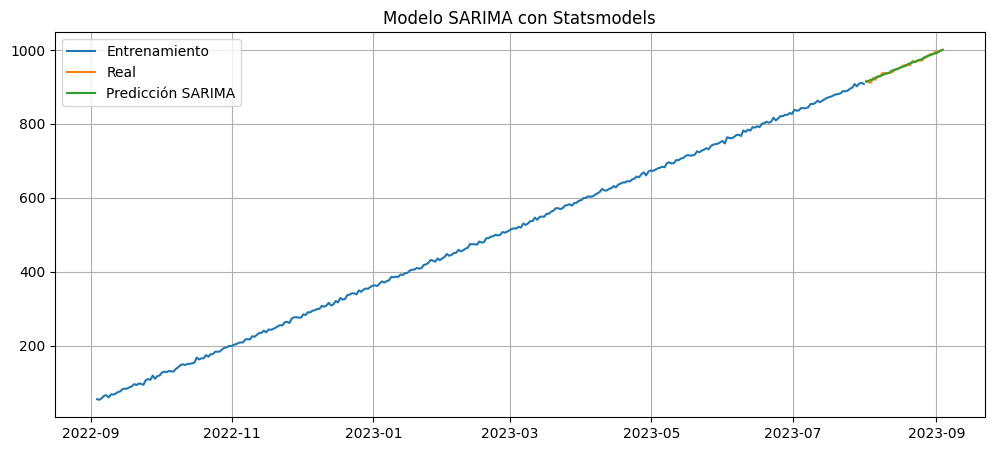

In [230]:
# Visualización
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['sales'], label='Entrenamiento')
plt.plot(test.index, test['sales'], label='Real')
plt.plot(test.index, test['predicciones'], label='Predicción SARIMA')
plt.legend()
plt.grid(True)
plt.title('Modelo SARIMA con Statsmodels')
plt.show()

El gráfico muestra tres líneas superpuestas que explican cómo funciona el modelo.
1. Entrenamiento => representa el comportamiento real de las ventas durante el periodo que usaste para entrenar el modelo.
2. Real => valores reales de ventas en el periodo de prueba
3. Predicción SARIMA => predicciones generadas por el modelo para ese mismo periodo de prueba

En neustro caso, la línea de predicción se superpone con la real. Lo que significa que el modelo está bastante ajustado.

# Guardar modelo

In [231]:
joblib.dump(resultado, 'modelo_sarima.pkl')  

['modelo_sarima.pkl']